In [4]:
import pandas as pd
import numpy as np
import nltk
import string

In [32]:
df = pd.read_csv("./fake_and_real_news_dataset.csv")
df.head()

,idd,title,text,label
0,Fq+C96tcx+,‘A target on Roe v. Wade ’: Oklahoma bill maki...,UPDATE: Gov. Fallin vetoed the bill on Friday....,REAL
1,bHUqK!pgmv,Study: women had to drive 4 times farther afte...,Ever since Texas laws closed about half of the...,REAL
2,4Y4Ubf%aTi,"Trump, Clinton clash in dueling DC speeches","Donald Trump and Hillary Clinton, now at the s...",REAL
3,_CoY89SJ@K,Grand jury in Texas indicts activists behind P...,A Houston grand jury investigating criminal al...,REAL
4,+rJHoRQVLe,"As Reproductive Rights Hang In The Balance, De...",WASHINGTON -- Forty-three years after the Supr...,REAL


In [33]:
len(df)

4594

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4594 entries, 0 to 4593
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   idd     4594 non-null   object
 1   title   4593 non-null   object
 2   text    4594 non-null   object
 3   label   4594 non-null   object
dtypes: object(4)
memory usage: 143.7+ KB


In [35]:
df.isnull().sum()

idd      0
title    1
text     0
label    0
dtype: int64

In [36]:
df = df.dropna()
df.reset_index(drop=True, inplace=True)

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4593 entries, 0 to 4592
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   idd     4593 non-null   object
 1   title   4593 non-null   object
 2   text    4593 non-null   object
 3   label   4593 non-null   object
dtypes: object(4)
memory usage: 143.7+ KB


In [38]:
df['label'].value_counts()

label
FAKE    2297
REAL    2296
Name: count, dtype: int64

In [39]:
df['title'] = df['title'].str.lower()
df['text'] = df['text'].str.lower()

def remove_punctuations(text):
    punctuations = set(string.punctuation)
    text = str(text)
    # return text.translate(str.maketrans('', '', punctuations))
    return " ".join([word for word in text.split() if word not in punctuations])
df['title'] = df['title'].apply(lambda x: remove_punctuations(x))
df['text'] = df['text'].apply(lambda x: remove_punctuations(x))

from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))
def remove_stopwords(text):
    return " ".join([word for word in text.split() if word not in STOPWORDS])
df['title'] = df['title'].apply(lambda x: remove_stopwords(x))
df['text'] = df['text'].apply(lambda x: remove_stopwords(x))

import re
def remove_spl_chars(text):
    text = re.sub('[^a-zA-Z0-9]', ' ', text)
    text = re.sub('\s+', ' ', text)
    return text
df['title'] = df['title'].apply(lambda x: remove_spl_chars(x))
df['text'] = df['text'].apply(lambda x: remove_spl_chars(x))

from spellchecker import SpellChecker
spell = SpellChecker()
def correct_spellings(text):
    corrected_text = []
    misspelled_text = spell.unknown(text.split())
    # print(misspelled_text)
    for word in text.split():
        if word in misspelled_text:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
            
    return " ".join(corrected_text)
df['title'] = df['title'].apply(lambda x: remove_spl_chars(x))
df['text'] = df['text'].apply(lambda x: remove_spl_chars(x))

In [40]:
from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer(language='english')
def stem(text):
    stemmed_sentence = " ".join(stemmer.stem(word) for word in text.split())
    return stemmed_sentence

df['title'] = df['title'].apply(lambda x: stem(x))
df['text'] = df['text'].apply(lambda x: stem(x))

In [41]:
df.head()

,idd,title,text,label
0,Fq+C96tcx+,a target roe v wade oklahoma bill make feloni ...,updat gov fallin veto bill friday head more la...,REAL
1,bHUqK!pgmv,studi women drive 4 time farther texa law clos...,ever sinc texa law close half state s abort cl...,REAL
2,4Y4Ubf%aTi,trump clinton clash duel dc speech,donald trump hillari clinton start line genera...,REAL
3,_CoY89SJ@K,grand juri texa indict activist behind plan pa...,houston grand juri investig crimin alleg plan ...,REAL
4,+rJHoRQVLe,reproduct right hang balanc debat moder drop ball,washington forti three year suprem court estab...,REAL


In [43]:
df['text'] = df['title'] + df['text']

### Sentiment Score

In [44]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
sid_obj= SentimentIntensityAnalyzer()

def sim_score(text):
    score = sid_obj.polarity_scores(text)
    sim = [score['neg'], score['neu'], score['pos'], score['compound']]
    return sim

df['Vector']= df['text'].apply(lambda x: sim_score(x))

df['Vector']

0       [0.065, 0.869, 0.067, -0.5563]
1       [0.087, 0.837, 0.076, -0.3477]
2        [0.113, 0.746, 0.141, 0.9399]
3        [0.068, 0.824, 0.108, 0.9777]
4         [0.092, 0.815, 0.093, 0.128]
                     ...              
4588    [0.206, 0.733, 0.061, -0.9979]
4589     [0.031, 0.805, 0.164, 0.9501]
4590        [0.057, 0.943, 0.0, -0.25]
4591    [0.075, 0.857, 0.068, -0.7036]
4592     [0.162, 0.75, 0.088, -0.9919]
Name: Vector, Length: 4593, dtype: object

### Readability

In [45]:
from textstat import textstat as txs

def read_score(text):
    sc = [txs.flesch_kincaid_grade(text), txs.gunning_fog(text), txs.automated_readability_index(text), txs.coleman_liau_index(text),
          txs.linsear_write_formula(text), txs.dale_chall_readability_score(text)]
    return sc

df['read_b'] = df['text'].apply(lambda x: read_score(x))
df['Vector'] = df['Vector'] + df['read_b']

### TF-IDF

In [46]:
from sklearn.feature_extraction.text import TfidfVectorizer
v_tf = TfidfVectorizer()
tf_b = v_tf.fit_transform(df['text'])
tf_b = tf_b.toarray()

In [47]:
tf_h = v_tf.transform(df['title'])
tf_h = tf_h.toarray()
len(tf_h[0])

45749

In [49]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn import preprocessing as prep

cos_sim = []
for i in range(4593):
    sim = cosine_similarity([tf_b[i]], [tf_h[i]])
    cos_sim.append(sim[0])
len(cos_sim)

4593

In [50]:
df['similarity'] = cos_sim
df['Vector'] = df['Vector'] + df['similarity']

## Word Embeddings

In [51]:
import torch
import torchtext

glove = torchtext.vocab.GloVe(name='6B', dim=50)

In [52]:
we_h = []
we_b = []
cos_we = []
def cosine_distance_wordembedding_method(s1, s2):
    vector_1 = np.mean([glove[word] for word in s1],axis=0)
    vector_2 = np.mean([glove[word] for word in s2],axis=0)
    we_h.append(vector_2)
    we_b.append(vector_1)
    sim = cosine_similarity([vector_1], [vector_2])
    cos_we.append(sim[0])

In [54]:
for i in range(4593):
    try:
        cosine_distance_wordembedding_method(df['text'][i], df['title'][i])
    except:
        KeyError
        continue

In [55]:
df['we_h'] = we_h
df['we_b'] = we_b
df['sim'] = cos_we

In [56]:
df['Vector'] = df['Vector'] + df['sim']

In [57]:
df['Vector'][1].shape

(10,)

In [58]:
for i in range(4593):
    try:
        df['Vector'][i] = np.hstack((df['Vector'][i], df['we_h'][i]))
        df['Vector'][i] = np.hstack((df['Vector'][i], df['we_b'][i]))
    except:
        KeyError
        continue

In [59]:
df['Vector'][0].shape

(110,)

## Model Building

In [70]:
df['label'].value_counts()

label
FAKE    2297
REAL    2296
Name: count, dtype: int64

In [71]:
df1 = df
df1['label'] = df1['label'].astype('category')

In [73]:
df1['label'] = df1['label'].cat.codes

,idd,title,text,label,Vector,read_b,similarity,we_h,we_b,sim
0,Fq+C96tcx+,a target roe v wade oklahoma bill make feloni ...,a target roe v wade oklahoma bill make feloni ...,1,"[1.5965052310505359, 2.400505231050536, 1.5985...","[277.8, 284.44, 356.6, 14.36, 60.0, 43.48]",[0.5335934797802417],"[-0.065633304, 0.7183272, 0.49586195, 0.578194...","[-0.082369, 0.68898135, 0.5542154, 0.5824735, ...",[0.99791175]
1,bHUqK!pgmv,studi women drive 4 time farther texa law clos...,studi women drive 4 time farther texa law clos...,1,"[1.677550439956361, 2.427550439956361, 1.66655...","[167.5, 171.39, 214.3, 13.43, 57.0, 28.88]",[0.593281643989259],"[-0.07910306, 0.6682605, 0.5590865, 0.55026704...","[-0.09034904, 0.69102806, 0.59157795, 0.601260...",[0.9972688]
2,4Y4Ubf%aTi,trump clinton clash duel dc speech,trump clinton clash duel dc speechtrump clinto...,1,"[1.5035895586147257, 2.136589558614726, 1.5315...","[135.1, 138.63, 174.3, 15.23, 59.0, 26.48]",[0.40136232329749544],"[-0.12142766, 0.6989292, 0.712759, 0.693803, 0...","[-0.10621903, 0.7054059, 0.5959553, 0.59803724...",[0.98922724]
3,_CoY89SJ@K,grand juri texa indict activist behind plan pa...,grand juri texa indict activist behind plan pa...,1,"[1.6227114787067918, 2.3787114787067916, 1.662...","[212.7, 216.07, 271.9, 16.56, 63.0, 36.01]",[0.560874360557988],"[-0.036584377, 0.6476298, 0.49182937, 0.490971...","[-0.07129202, 0.6892758, 0.56678724, 0.590555,...",[0.9938371]
4,+rJHoRQVLe,reproduct right hang balanc debat moder drop ball,reproduct right hang balanc debat moder drop b...,1,"[1.4239286178704087, 2.1469286178704086, 1.424...","[109.4, 111.6, 140.2, 13.95, 60.0, 23.76]",[0.34038455001075907],"[-0.10992066, 0.67590123, 0.5319534, 0.6684608...","[-0.09172998, 0.68299496, 0.5671585, 0.5888638...",[0.99154407]


In [74]:
df1['label'].value_counts()

label
0    2297
1    2296
Name: count, dtype: int64

In [75]:
from sklearn.model_selection import train_test_split
x_df = df['Vector']
y_df = df1['label']
x_df.head()
x_train, x_test, y_train, y_test = train_test_split(x_df, y_df, test_size=0.2, random_state=10, stratify=y_df)

In [76]:
len(x_train), len(y_train)

(3674, 3674)

In [77]:
X_train = []
for l in x_train:
    s = []
    for data in l:
        s.append(float(data))
    X_train.append(s)

In [78]:
X_test = []
for l in x_test:
    s = []
    for data in l:
        s.append(float(data))
    X_test.append(s)

In [79]:
X_train = np.array(X_train)

In [80]:
type(X_train[0]), type(y_train[0])

(numpy.ndarray, numpy.int8)

## Random Forest

In [81]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

In [82]:
y_pred = rf.predict(X_test)
y_pred.shape

(919,)

In [83]:
score = accuracy_score(y_pred, y_test)
score

0.7747551686615887

## XG Boost

In [84]:
from xgboost import XGBClassifier
clf_xg = XGBClassifier()
clf_xg.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [85]:
y_pred = clf_xg.predict(X_test)
score = accuracy_score(y_pred, y_test)
score

0.7562568008705114

## SVC

In [86]:
from sklearn.svm import LinearSVC
clf_svc = LinearSVC(verbose=0)
clf_svc.fit(X_train, y_train)

d:\Research Projects\res\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
d:\Research Projects\res\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC()

In [87]:
y_pred = clf_svc.predict(X_test)
score = accuracy_score(y_pred, y_test)
score

0.5168661588683352

## Gaussian NB

In [88]:
from sklearn.naive_bayes import GaussianNB
clf_nb = GaussianNB()
clf_nb.fit(X_train, y_train)

GaussianNB()

In [89]:
y_pred = clf_nb.predict(X_test)
score = accuracy_score(y_pred, y_test)
score

0.6137105549510338

## AdaBoost

In [90]:
from sklearn.ensemble import AdaBoostClassifier
clf_ad = AdaBoostClassifier()
clf_ad.fit(X_train, y_train)

AdaBoostClassifier()

In [91]:
y_pred = clf_ad.predict(X_test)
score = accuracy_score(y_pred, y_test)
score

0.7290533188248096

## KNN

In [92]:
from sklearn.neighbors import KNeighborsClassifier
clf_knn = KNeighborsClassifier()
clf_knn.fit(X_train, y_train)

KNeighborsClassifier()

In [93]:
y_pred = clf_knn.predict(X_test)
score = accuracy_score(y_pred, y_test)
score

0.6420021762785637

In [94]:
x_pred = clf_knn.predict(X_train)
score = accuracy_score(x_pred, y_train)
score

0.753402286336418

## MLP

In [96]:
from sklearn.neural_network import MLPClassifier
clf_mlp = MLPClassifier(hidden_layer_sizes=(15,15),
                    random_state=5,
                    verbose=True,
                    learning_rate_init=0.01)
clf_mlp.fit(X_train, y_train)

Iteration 1, loss = 3.65466712
Iteration 2, loss = 0.89052530
Iteration 3, loss = 0.70214640
Iteration 4, loss = 0.69528261
Iteration 5, loss = 0.68072878
Iteration 6, loss = 0.70242148
Iteration 7, loss = 0.68847599
Iteration 8, loss = 0.71275631
Iteration 9, loss = 0.68439865
Iteration 10, loss = 0.68586165
Iteration 11, loss = 0.69031131
Iteration 12, loss = 0.67653580
Iteration 13, loss = 0.67890040
Iteration 14, loss = 0.68847276
Iteration 15, loss = 0.68818778
Iteration 16, loss = 0.67533108
Iteration 17, loss = 0.67165298
Iteration 18, loss = 0.66576647
Iteration 19, loss = 0.65788171
Iteration 20, loss = 0.65154886
Iteration 21, loss = 0.64285485
Iteration 22, loss = 0.65892585
Iteration 23, loss = 0.64096070
Iteration 24, loss = 0.63796155
Iteration 25, loss = 0.66040110
Iteration 26, loss = 0.63584450
Iteration 27, loss = 0.63153960
Iteration 28, loss = 0.62117624
Iteration 29, loss = 0.62779428
Iteration 30, loss = 0.62728105
Iteration 31, loss = 0.61923027
Iteration 32, los

MLPClassifier(hidden_layer_sizes=(15, 15), learning_rate_init=0.01,
              random_state=5, verbose=True)

In [97]:
x_pred = clf_mlp.predict(X_train)
score = accuracy_score(x_pred, y_train)
score

0.6995100707675558

In [98]:
y_pred = clf_mlp.predict(X_test)
score = accuracy_score(y_pred, y_test)
score

0.6746463547334058

## K-fold Cross Validation

In [99]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5)
X_df = []
for l in x_df:
    s = []
    for data in l:
        s.append(float(data))
    X_df.append(s)

In [100]:
def get_score(model, x_tr, x_te, y_tr, y_te):
    model.fit(x_tr, y_tr)
    return model.score(x_te, y_te)

from sklearn.model_selection import GroupKFold, StratifiedKFold
gkf = GroupKFold()
skf =  StratifiedKFold(n_splits=5, shuffle=True, random_state=10)

In [101]:
score_xg = []
score_rf = []
score_svc = []
score_gnb = []
score_ab = []
score_knn = []
score_mlp = []
X_df = np.array(X_df)

In [102]:
for train_idx, test_idx in skf.split(X_df, y_df):
    x_tr, y_tr = X_df[train_idx], y_df.loc[train_idx]
    x_te, y_te = X_df[test_idx], y_df.loc[test_idx]
    score_xg.append(get_score(clf_xg, x_tr, x_te, y_tr, y_te))
    score_svc.append(get_score(clf_svc, x_tr, x_te, y_tr, y_te))
    score_gnb.append(get_score(clf_nb, x_tr, x_te, y_tr, y_te))
    score_ab.append(get_score(clf_ad, x_tr, x_te, y_tr, y_te))
    score_knn.append(get_score(clf_knn, x_tr, x_te, y_tr, y_te))
    score_mlp.append(get_score(clf_mlp, x_tr, x_te, y_tr, y_te))
    score_rf.append(get_score(rf, x_tr, x_te, y_tr, y_te))

d:\Research Projects\res\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
d:\Research Projects\res\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Iteration 1, loss = 3.78793415
Iteration 2, loss = 0.96482852
Iteration 3, loss = 0.70658685
Iteration 4, loss = 0.73605968
Iteration 5, loss = 0.69638642
Iteration 6, loss = 0.68408623
Iteration 7, loss = 0.68361489
Iteration 8, loss = 0.68747670
Iteration 9, loss = 0.71901511
Iteration 10, loss = 0.67033708
Iteration 11, loss = 0.66073527
Iteration 12, loss = 0.66654248
Iteration 13, loss = 0.68031321
Iteration 14, loss = 0.65953225
Iteration 15, loss = 0.64460042
Iteration 16, loss = 0.63138375
Iteration 17, loss = 0.63252836
Iteration 18, loss = 0.63555557
Iteration 19, loss = 0.63003694
Iteration 20, loss = 0.62023233
Iteration 21, loss = 0.62368774
Iteration 22, loss = 0.62763893
Iteration 23, loss = 0.63230765
Iteration 24, loss = 0.62657266
Iteration 25, loss = 0.61592474
Iteration 26, loss = 0.61527687
Iteration 27, loss = 0.61700478
Iteration 28, loss = 0.61322884
Iteration 29, loss = 0.62865368
Iteration 30, loss = 0.61176728
Iteration 31, loss = 0.61606449
Iteration 32, los

d:\Research Projects\res\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
d:\Research Projects\res\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Iteration 1, loss = 3.73357526
Iteration 2, loss = 1.01530110
Iteration 3, loss = 0.70664382
Iteration 4, loss = 0.72722826
Iteration 5, loss = 0.69964633
Iteration 6, loss = 0.70820887
Iteration 7, loss = 0.68315976
Iteration 8, loss = 0.68356215
Iteration 9, loss = 0.69543172
Iteration 10, loss = 0.68687079
Iteration 11, loss = 0.70319630
Iteration 12, loss = 0.70815617
Iteration 13, loss = 0.69380846
Iteration 14, loss = 0.66771611
Iteration 15, loss = 0.66297178
Iteration 16, loss = 0.65645966
Iteration 17, loss = 0.65344875
Iteration 18, loss = 0.66556837
Iteration 19, loss = 0.64222802
Iteration 20, loss = 0.65313522
Iteration 21, loss = 0.66078524
Iteration 22, loss = 0.64941171
Iteration 23, loss = 0.63929041
Iteration 24, loss = 0.63464863
Iteration 25, loss = 0.63456680
Iteration 26, loss = 0.63260079
Iteration 27, loss = 0.64545072
Iteration 28, loss = 0.62691780
Iteration 29, loss = 0.64517251
Iteration 30, loss = 0.64758371
Iteration 31, loss = 0.63157281
Iteration 32, los

d:\Research Projects\res\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
d:\Research Projects\res\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Iteration 1, loss = 3.84420179
Iteration 2, loss = 0.94852858
Iteration 3, loss = 0.71759596
Iteration 4, loss = 0.69236627
Iteration 5, loss = 0.70217688
Iteration 6, loss = 0.70969053
Iteration 7, loss = 0.70292558
Iteration 8, loss = 0.73200135
Iteration 9, loss = 0.70282285
Iteration 10, loss = 0.69585339
Iteration 11, loss = 0.68980341
Iteration 12, loss = 0.68187488
Iteration 13, loss = 0.67975817
Iteration 14, loss = 0.69229660
Iteration 15, loss = 0.68143278
Iteration 16, loss = 0.67921472
Iteration 17, loss = 0.69123126
Iteration 18, loss = 0.68202231
Iteration 19, loss = 0.67877342
Iteration 20, loss = 0.68175604
Iteration 21, loss = 0.68944423
Iteration 22, loss = 0.67094407
Iteration 23, loss = 0.67141398
Iteration 24, loss = 0.65512907
Iteration 25, loss = 0.65805186
Iteration 26, loss = 0.64550827
Iteration 27, loss = 0.64251956
Iteration 28, loss = 0.64589417
Iteration 29, loss = 0.63999524
Iteration 30, loss = 0.64464275
Iteration 31, loss = 0.66480760
Iteration 32, los

d:\Research Projects\res\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
d:\Research Projects\res\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Iteration 1, loss = 3.48319552
Iteration 2, loss = 0.89771777
Iteration 3, loss = 0.73086612
Iteration 4, loss = 0.69668309
Iteration 5, loss = 0.73080509
Iteration 6, loss = 0.67524073
Iteration 7, loss = 0.68871592
Iteration 8, loss = 0.67989498
Iteration 9, loss = 0.68133675
Iteration 10, loss = 0.67716912
Iteration 11, loss = 0.68217577
Iteration 12, loss = 0.69087799
Iteration 13, loss = 0.72261166
Iteration 14, loss = 0.69528309
Iteration 15, loss = 0.67260796
Iteration 16, loss = 0.67011030
Iteration 17, loss = 0.67570843
Iteration 18, loss = 0.66777484
Iteration 19, loss = 0.67767851
Iteration 20, loss = 0.67416467
Iteration 21, loss = 0.67424116
Iteration 22, loss = 0.67024120
Iteration 23, loss = 0.66570803
Iteration 24, loss = 0.66849429
Iteration 25, loss = 0.66438498
Iteration 26, loss = 0.66453020
Iteration 27, loss = 0.66319920
Iteration 28, loss = 0.65767871
Iteration 29, loss = 0.66282337
Iteration 30, loss = 0.66027292
Iteration 31, loss = 0.65836636
Iteration 32, los

d:\Research Projects\res\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
d:\Research Projects\res\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Iteration 1, loss = 3.16921773
Iteration 2, loss = 0.79980000
Iteration 3, loss = 0.75387883
Iteration 4, loss = 0.70537327
Iteration 5, loss = 0.69156079
Iteration 6, loss = 0.72642843
Iteration 7, loss = 0.74113151
Iteration 8, loss = 0.68006931
Iteration 9, loss = 0.70134795
Iteration 10, loss = 0.67442642
Iteration 11, loss = 0.66899030
Iteration 12, loss = 0.66888299
Iteration 13, loss = 0.65635292
Iteration 14, loss = 0.63370039
Iteration 15, loss = 0.66008201
Iteration 16, loss = 0.64590372
Iteration 17, loss = 0.65617871
Iteration 18, loss = 0.65663086
Iteration 19, loss = 0.64344080
Iteration 20, loss = 0.64577164
Iteration 21, loss = 0.62173511
Iteration 22, loss = 0.61983851
Iteration 23, loss = 0.62476256
Iteration 24, loss = 0.61940003
Iteration 25, loss = 0.61255108
Iteration 26, loss = 0.61524132
Iteration 27, loss = 0.61284080
Iteration 28, loss = 0.61958717
Iteration 29, loss = 0.60876671
Iteration 30, loss = 0.61698644
Iteration 31, loss = 0.61089059
Iteration 32, los

In [103]:
print("XGB: ", max(score_xg))
print("Random Forest: ", max(score_rf))
print("SVC: ", max(score_svc))
print("GNB: ", max(score_gnb))
print("Ada Boost: ", max(score_ab))
print("KNN: ", max(score_knn))
print("MLP: ", max(score_mlp))

XGB:  0.8041349292709467
Random Forest:  0.7878128400435256
SVC:  0.7105549510337323
GNB:  0.6605005440696409
Ada Boost:  0.7519042437431991
KNN:  0.6583242655059848
MLP:  0.7007616974972797


In [104]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier  # Replace with your chosen classifier

# Replace the following with your dataset and features
X = X_df
y = y_df

# Number of folds for cross-validation
num_folds = range(2, 10)  # Vary the number of folds from 2 to 10

# Initialize an empty list to store mean accuracies for each fold

model_list = [clf_xg, clf_svc, clf_nb, clf_ad, clf_knn, clf_mlp, rf]
model_score = {}
model_names = ['XGB', 'SVC', 'NB', 'ADB', 'KNN', 'MLP', 'RF']
# Iterate through different numbers of folds
count = 0
for model in model_list:
    mean_accuracies = []
    for folds in num_folds:
        # Create a KFold cross-validation object
        kfold = KFold(n_splits=folds, shuffle=True, random_state=42)

        # Replace RandomForestClassifier with your chosen classifier
        # model = RandomForestClassifier()
        
        
        # Perform cross-validation and get accuracy scores
        
    
        scores = cross_val_score(model, X, y, cv=kfold, scoring='accuracy')
        mean_accuracies.append(np.mean(scores))
    model_score[model_names[count]] = mean_accuracies
    count += 1

    # Calculate and store the mean accuracy for this fold
    # mean_accuracies.append(np.mean(scores))

d:\Research Projects\res\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
d:\Research Projects\res\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
d:\Research Projects\res\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
d:\Research Projects\res\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
d:\Research Projects\res\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` expl

Iteration 1, loss = 4.38759806
Iteration 2, loss = 0.83862110
Iteration 3, loss = 0.76001952
Iteration 4, loss = 0.74133735
Iteration 5, loss = 0.74733981
Iteration 6, loss = 0.69715329
Iteration 7, loss = 0.74598466
Iteration 8, loss = 0.75244004
Iteration 9, loss = 0.70828275
Iteration 10, loss = 0.77129388
Iteration 11, loss = 0.71443300
Iteration 12, loss = 0.68761570
Iteration 13, loss = 0.68005179
Iteration 14, loss = 0.70770011
Iteration 15, loss = 0.76477397
Iteration 16, loss = 0.73609496
Iteration 17, loss = 0.76086853
Iteration 18, loss = 0.74481520
Iteration 19, loss = 0.67387766
Iteration 20, loss = 0.66094642
Iteration 21, loss = 0.65726762
Iteration 22, loss = 0.66249601
Iteration 23, loss = 0.65663343
Iteration 24, loss = 0.68951035
Iteration 25, loss = 0.68365314
Iteration 26, loss = 0.65812680
Iteration 27, loss = 0.63335451
Iteration 28, loss = 0.64064905
Iteration 29, loss = 0.67503077
Iteration 30, loss = 0.64976097
Iteration 31, loss = 0.63663496
Iteration 32, los

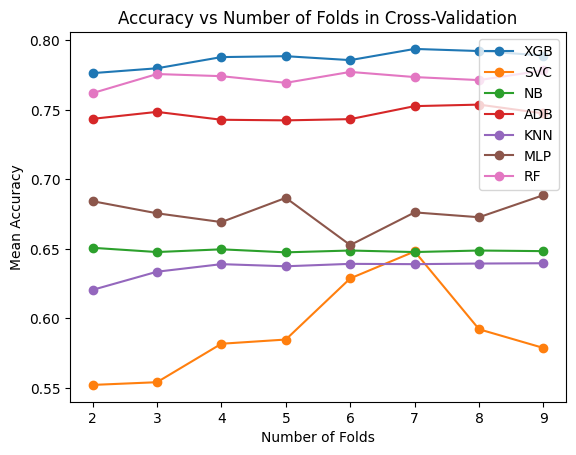

In [105]:
i = 0
for model in model_list:
    plt.plot(num_folds, model_score[model_names[i]], marker='o')
    i += 1
plt.title('Accuracy vs Number of Folds in Cross-Validation')
plt.legend(model_names, loc='best')
plt.xlabel('Number of Folds')
plt.ylabel('Mean Accuracy')
plt.show()